# Introduction Tree Learning: Exercise 1



In this practical you will have your first real contact with supervised machine learning applied to real biological data. 

Your task is to establish, which biomarkers (or features/attributes) influence the outcome. This execise goes through the clinical biomarkers and you will have a look at the data using decision trees and random forrests. The author of the paper (see below) has established that no real clinical biomarkers could be found. Instead, he found some other biomarkers, which will be part of the  second excerice. The file 

```
'clinical_biomarkers.csv'
``` 

Contains those clinical biomarkers.

Please go through the exercise/tutorial and establish that you know what you are doing. In the second exercise you will have a look into the informative (genetic) biomarkers. 

For each exercise: Which features are the most informatives?



## Data origin

The data originates form the following publication:

https://bmcbioinformatics.biomedcentral.com/articles/10.1186/s12859-016-1292-2

(going down to section Additional files - Additional file 3 will give you the full ist of raw data)

For the purpose of the exercise, we transformed the data already.

Before goint into downloading the data - some common imports



In [61]:
import os
import sys
import pandas as pd
import numpy as np


import matplotlib.pyplot as plt # plotting and visulisation
import seaborn as sns # nicer (easier) visualisation
%matplotlib inline


## Some required import for plotting a learnt tree 

Here, you can load a small helper file, allowing to plot the learnt tree using a programme called graphviz.  
This library assume that graphviz is installed locally (which is true for the Jupyer Lab environment on bearportal)


In [22]:
# own mini- library
import session_helpers
import IPython.display


## Loading in the file and setting the first column to be the index

In [63]:
biomarkers_file_csv = 'clinical_biomarkers.csv'

df = pd.read_csv(biomarkers_file_csv)
df = df.set_index(['Sample'])

### Task For You 
- Please have a look at the loaded data. How many columns/attributes does it have? 
- What can you say about the values in each of the columns? Just have a closer look.

In [5]:
### Complete the section
# ....

### Mapping classes into positive and negative

The following maps examples either to be positive or negative. 
You can exclude a set of example by putting them into comments (just let the start of the line be an ```#``` - see for example ```Low```in the code below.). If there is no mapping, the values will be set to ```None``` or ```NaN``` (the numpy version of ```None```).  

The final line in the code, keeps only entries, which have a none ```NaN``` entry in the column ```'Response'```.


In [64]:
# make a copy of the dataframe
df_ex = df.copy()
# map Response to interesting l=classes
df_ex['Response'] = df_ex['Response'].map(
    {
     'C.R.':'negative', 
     'C.':'negative',
#     'Low':'negative',
     'Int. I.':'negative',
     'Int. II.':'negative',
     'Int. II. R.':'negative',
     'High':'positive',
     'High R.':'negative',
    })


# drop entries, which do not have a class label (this results in not mapping it to any new target class)
# if filter on the column 'target', looking for entries which are None or NaN
df_ex = df_ex[df_ex['Response'].notna()]


## Plotting the values of all columns

Here we use the melt function of pandas. This function allows the values to be plotted in a nice fashion. Just click on Run and see. 

Are you able to spot an attribute or two, separating positive from negative?


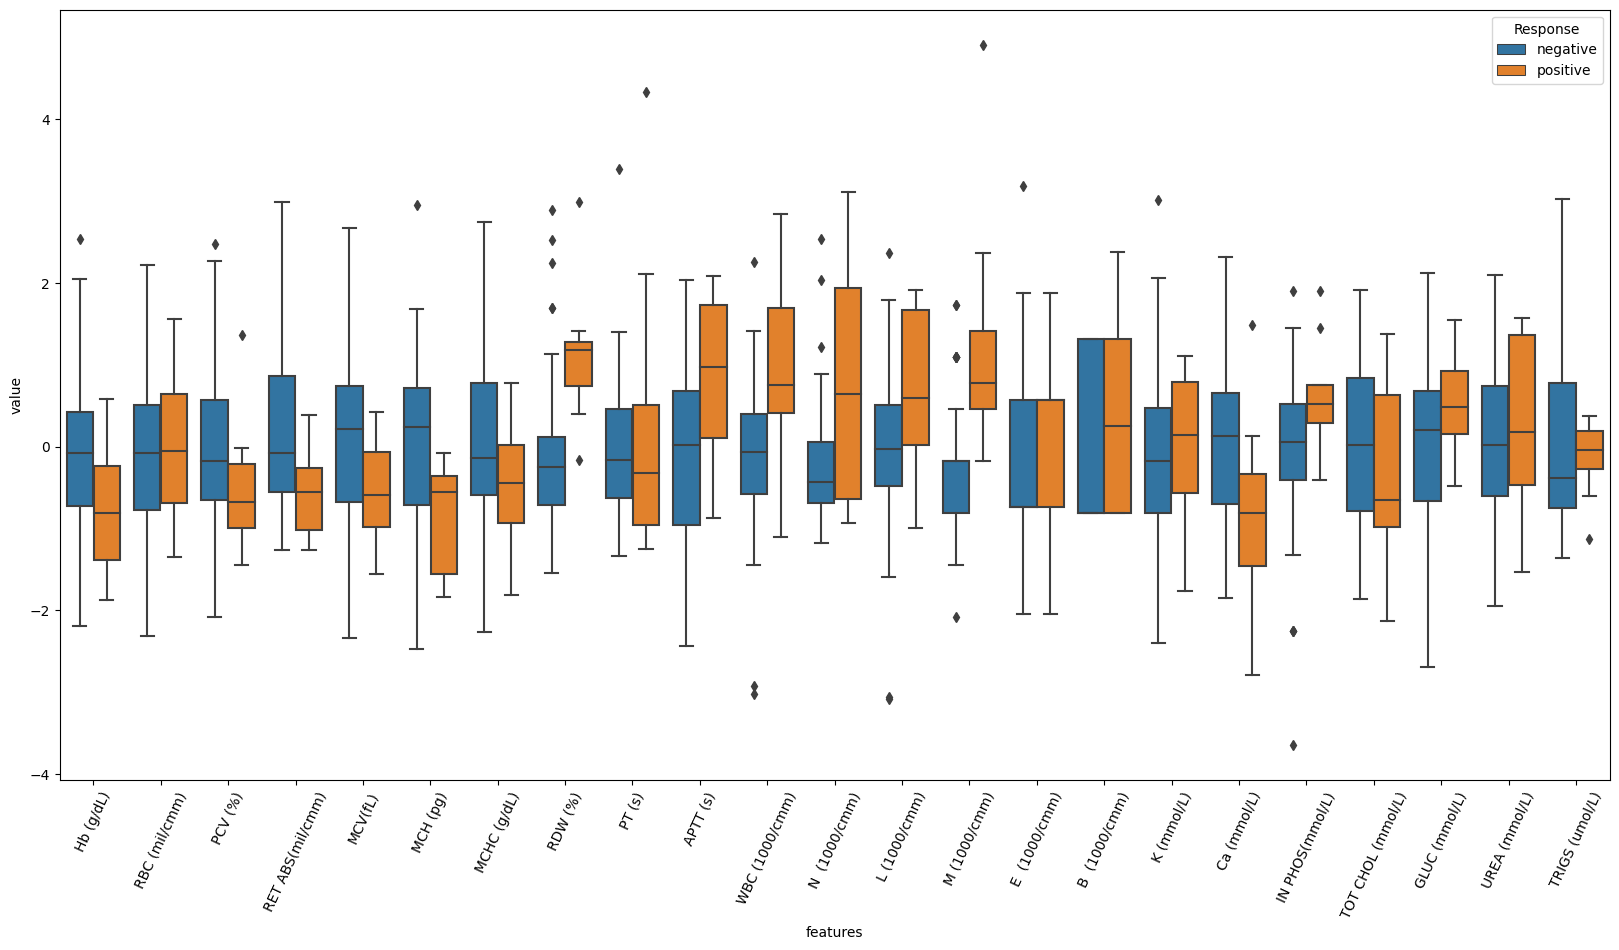

In [65]:
plot_data_melt = pd.melt(df_ex,id_vars="Response",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(20,10))
ax = sns.boxplot(x="features", y="value", hue="Response", data=plot_data_melt)
ticks_information = plt.xticks(rotation=65)

## First Decision Tree Model

You might or might not have been able to spot a pattern in the data in order to distinguish positive from negative examples. Here, we build a first decision tree to see what underlying pattern can be found. 

Before doing this, we split the data into data X and labels y.


In [66]:
y = df_ex['Response']
X = df_ex.drop(['Response'],axis=1)

## Train/Test Split

For an initial evaluation of the model, we use a simple train/test split. 

Please note: **This is only okay for a first  look at the data!!!**

In [67]:
from sklearn.model_selection import train_test_split
# simple train and test split
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=15)

### Import the DecisionTreeClassifier

In [68]:
from sklearn.tree import DecisionTreeClassifier


### Training the clasifier

In sklean, we first have to set up the decision tree model and then train it using our training data. The model expects at least two inputs: the actual data and the labels. 

In [69]:
dt_model = DecisionTreeClassifier(random_state=0)
dtree = dt_model.fit(X_train,y_train)

### Analysing the learnt tree

In [12]:
dtree

DecisionTreeClassifier(random_state=0)

Now, this is a bit dissapointing. You can use the model to predict, but the printout is not very informative. To overcome this, I have written a plotting function (hidden in the session_helpers import from the beginning).

### Plotting the  Tree




Here we are going to plot the tree inside the model. This will only work when Graphviz and the pyton module for graphviz are installed. 

You should see something similar to the following:

![2 Class Tree](dtree.png)


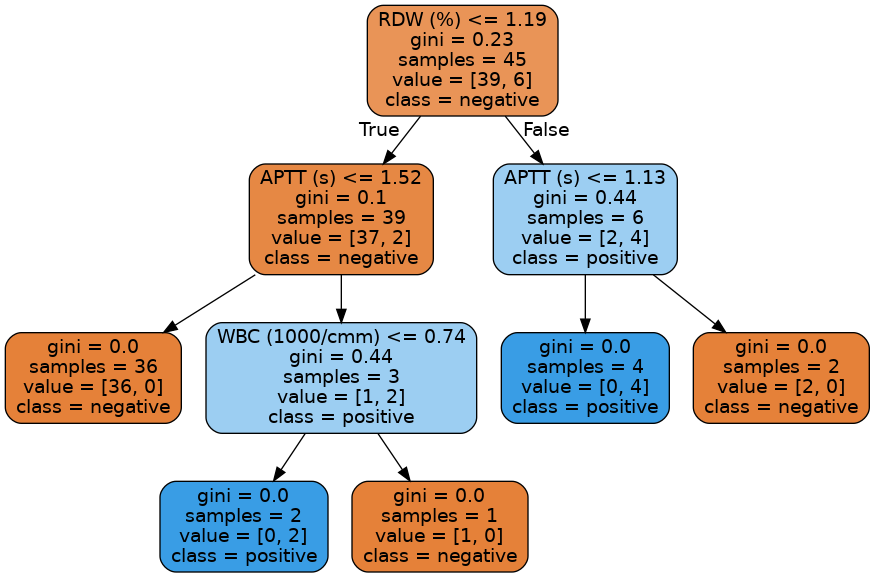

In [70]:
# for visulisation:
image = session_helpers.plot_tree(dtree,X_test,y_test,rotate=False,max_depth=None)
IPython.display.Image(image)

Play around with some of the settings of the decision tree as well as (if you like) with ```rotate``` and ```max_depth``` in the plotting command.

# A more realistic validation scenario: k-fold cross-validation

The learning of the tree in the previous sections was only a first glimpse of a validation. Here we use a proper k-fold cross validation to estimate the performance of the learning algorithm. To do this, we need some additional objects (modules)

In [71]:
from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix

## Cross validation

As we do not want to perform the splitting and merging of folds ourselves, we use the prediefined cross validation function in sklearn. 

Here, we use a simple 5-fold CV. Have a look what other parameters are possible (this might involve you searching the net!)

Within each of the folds, we plot the confusion matrix. 

What is the problem with using ```KFold```? Have a look at this function [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html).

**Some information  about  the code:**

The python function ```enumerate(...)```, takes an iterable object, such as a list, and combines it with a counter
Try out the results  of 
```python
list(enumerate([10,20,30,40]))
```
PS: The function ```list(...```  coverts an iterable object into a list

In [75]:
# generate the folds
kf = KFold(n_splits=5, random_state=15, shuffle=True)

# for loop for each fold
for count_k,  (train_index, test_index) in enumerate(kf.split(X)):
    # create local datasets
    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]
    
    # fit the tree
    dtree = dt_model.fit(X_train,y_train)
    # predict on test fold 
    y_test_predicted = dtree.predict(X_test)
    
    # print
    print('Confusion Matrix (k={})'.format(count_k))
    print(confusion_matrix(y_test,y_test_predicted))
    

Confusion Matrix (k=0)
[[7 5]
 [1 0]]
Confusion Matrix (k=1)
[[9 2]
 [1 0]]
Confusion Matrix (k=2)
[[7 1]
 [2 2]]
Confusion Matrix (k=3)
[[9 2]
 [1 0]]
Confusion Matrix (k=4)
[[8 3]
 [1 0]]


In [ ]:
## ---- Complete the Code ---- ##

## ....
## ...
## ...

### A more realistic setting

Actually, the data contained more than two classes. In the following, we use a one-to-one mapping. This has the same effect of leaving the 'Response' column unchanged. However, if you would like to delete one group, say 'C.', you can just comment this mapping out (see above with 'Low') 

Please check the original publication, what the correct mapping would be (look for the section 'Random forest classification')

Furthermore, we perform the same kind of analysis as above.

In [79]:
df_ex = df.copy()
df_ex['Response'] = df_ex['Response'].map(
    {
        'C.':'C.',
        'C. R.':'C. R.',
        'Low':'Low',
        'Int. I.':'Int. I.',
        'Int. II.':'Int. II.',
        'Int. II. R.':'Int. II. R.',
        'High':'High',
        'High R.':'High R.',
    })

df_ex = df_ex[df_ex['Response'].notna()]

# For consitency
# target column
y = df_ex['Response']
# this drops the column 'Response' for the dataframe and stores it in X
X = df_ex.drop(['Response'],axis=1)

print(X)

        Hb (g/dL)  RBC (mil/cmm)   PCV (%)  RET ABS(mil/cmm)   MCV(fL)  \
Sample                                                                   
1        0.092087      -0.933507  0.677989          1.571541  2.096461   
2        0.255541       0.283637 -0.277325         -1.259227 -0.722841   
4       -0.234821       0.477273 -0.595763         -0.079740 -1.349353   
5        1.072810       1.058183  1.367938         -0.551535  0.269135   
6        2.543896       1.611430  1.686377         -1.023329 -0.096330   
...           ...            ...       ...               ...       ...   
73       0.418995       0.919871  0.784135          0.156157 -0.252958   
74       0.418995       0.975196  0.677989         -1.259227 -0.461795   
76      -0.725183      -1.099482 -0.542690         -1.023329  0.791228   
77      -1.378999       0.477273 -0.648836         -0.315637 -1.401562   
78       2.053534       0.449611  2.270180         -0.787432  2.096461   

        MCH (pg)  MCHC (g/dL)   RDW (

### Plotting the data



In [ ]:
plot_data_melt = pd.melt(df_ex,id_vars="Response",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(60,10))
sns.boxplot(x="features", y="value", hue="Response", data=plot_data_melt)
ticks_information = plt.xticks(rotation=65)

# Simple Train/Test - Decision Tree

Warning - more than two classes! What does that mean later on?


In [77]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=3)
dtree = dt_model.fit(X_train,y_train)
dtree.get_params()


{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 0,
 'splitter': 'best'}

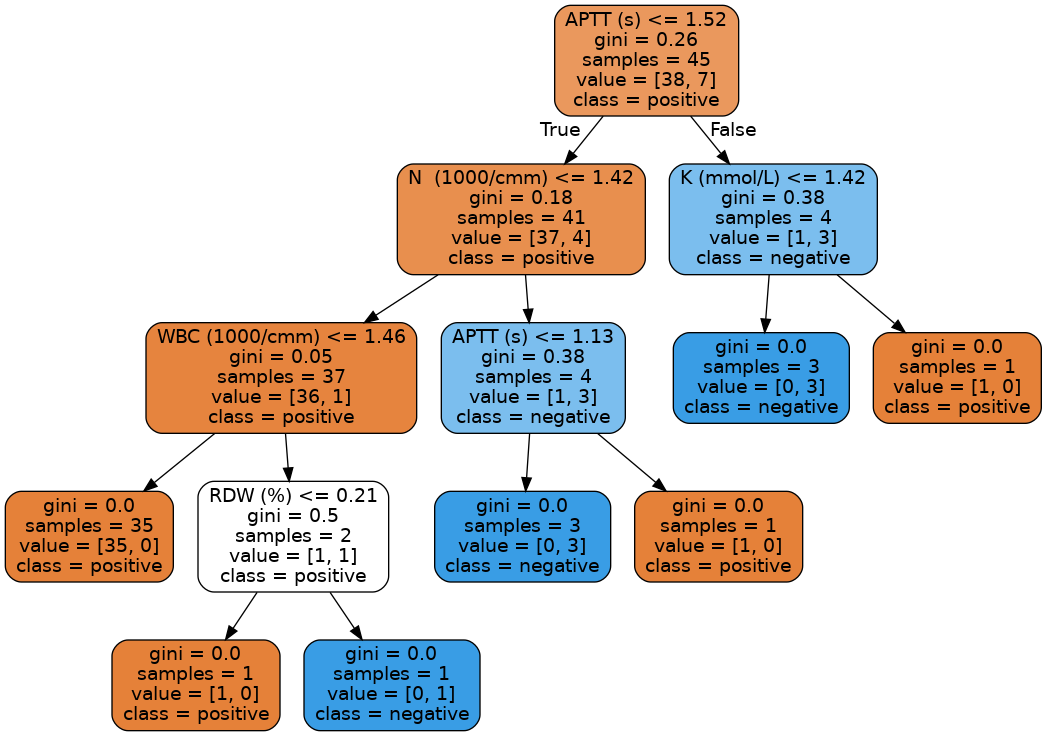

In [78]:
# for visulisation:
image = session_helpers.plot_tree(dtree,X_test,y_test,rotate=False,max_depth=None)
IPython.display.Image(image)


#### Question 1 : Which feature has been used most frequently ? 
#### Answer : 'APTT (s)', 'GLUC (mmol/L)'


#### Question 2 : Compltet he code segment below by adding a code snippted to print accuracy and F1 score for each fold.  

#### Question 3 : Which Fold has best accuracy and which one have the worst accuracy ?
#### Answer : Fold 2 has the best accuracy and Fold 5 has the worst accuracy. 

In [22]:
## A Five Fold Cross Validation Approach ##

from sklearn.metrics import accuracy_score,f1_score

kf = StratifiedKFold(n_splits=5, random_state=15, shuffle=True)
for count_k,(train_index, test_index) in enumerate(kf.split(X,y)):
    X_train = X.iloc[train_index]
    X_test  = X.iloc[test_index]
    y_train = y.iloc[train_index]
    y_test  = y.iloc[test_index]
    dtree = dt_model.fit(X_train,y_train)
    y_test_predicted = dtree.predict(X_test)
    print('Confusion Matrix (k={})'.format(count_k))
    print(confusion_matrix(y_test,y_test_predicted))
    ## print('Accuracy:     {}'.format(accuracy_score(y_test,y_test_predicted)))
    ## print('F1 Score:     {}'.format(f1_score(y_test,y_test_predicted, average='macro',)))

    print()


Accuracy:     0.42857142857142855
F1 Score:     0.3761904761904762

Accuracy:     0.5714285714285714
F1 Score:     0.5476190476190476

Accuracy:     0.3076923076923077
F1 Score:     0.23129251700680273

Accuracy:     0.3076923076923077
F1 Score:     0.24285714285714288

Accuracy:     0.0
F1 Score:     0.0



#### Your Task : Train a Decision Tree Classifier and apply it on the test data set. 

- Task 1 : Train a decision tree classifier on the open ml Lipid data set. 
Data Link : https://openml.org/search?type=data&status=active&id=1480

- Task 2 : Vizualize the trained decision tree. 

- Task 3 : Print the performance metrics on the test data
           3.1 Print the confusion metric.
           3.2 Print the accuracy
           3.3 Plot the ROC curve. 

In [ ]:
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import LeaveOneOut, GridSearchCV, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


## Task 1 : Load the open ML lipid data set. 
lipid_data = fetch_openml( data_id = "1480" )

X = lipid_data.data
y = lipid_data.target

## We replace the 'Female' to 0 and 'Male' to 1 
# ...

## We replace the '1' to 0 and '2' to 1 
# ...
# ...

In [ ]:
### Task 2 : Vizualize the tree best decision tree



In [ ]:
##  Task 3 : Print the performance metrics on the test data
##            3.1 Print the confusion metric.
##            3.2 Print the accuracy.
##            3.3 Plot the ROC curve. 


import matplotlib.pyplot as plt # plotting and visulisation
import seaborn as sns # nicer (easier) visualisation
%matplotlib inline
from sklearn.metrics import RocCurveDisplay

## Evaluate on test data
# y_test_predicted = ...

print('Confusion Matrix of best model on test')
# print( ... )
# print("Decision Tree Accuracy on test data: ", ... )

# ROC curve for test data
# ...
